In [9]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"
atlas = Atlas.from_name(ATLAS)
k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
REFNET = ("Default",)
INTER = ("Default",)

sns.reset_defaults()
# TODO Deconfounding in the pipeline?

In [10]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    groupkfold=True,
    net="".join(REFNET),
    inter="".join(INTER)
)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 9 subjects because of lacking MMMSE


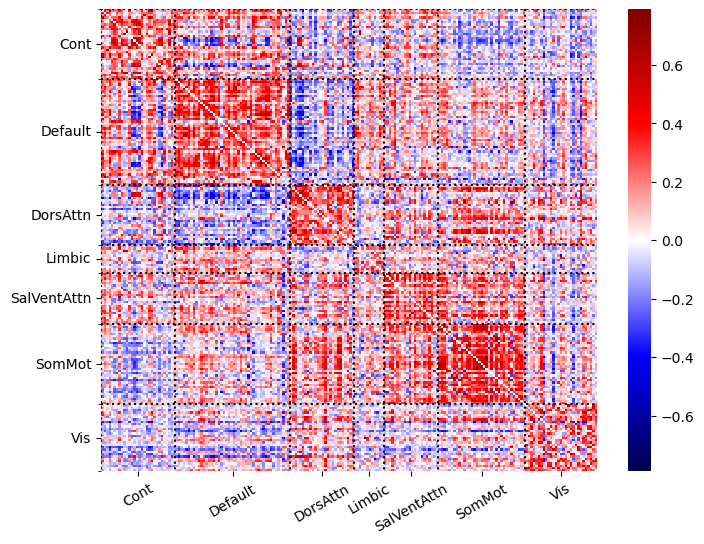

In [11]:
plot_matrix(matrices[1], atlas)
plt.show()

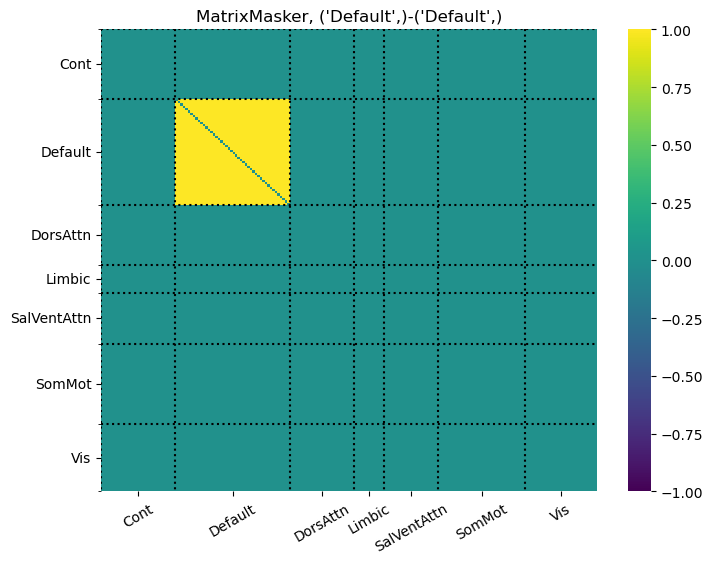

In [12]:
masker = MatrixMasker(REFNET, INTER).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

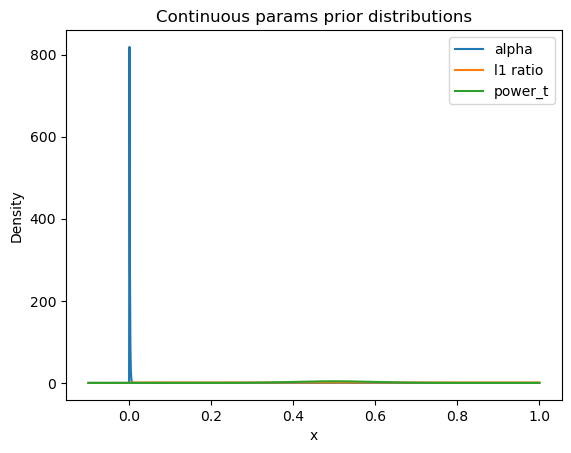

In [13]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [14]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from cogpred.supervised import macro_f1
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)


clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER)),
    ("scaler", preprocessing.StandardScaler()),
    #("smote", SMOTE(
    #    random_state=1234,
    #    sampling_strategy="minority",
    #    k_neighbors=NearestNeighbors(n_neighbors=2, n_jobs=-1)
    #)),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [16]:
y = metadata.cluster_label.values
search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
1,0.987819,0.106004,0.049518,0.029337,0.000218,0.860217,hinge,0.331347,"{'classifier__alpha': 0.00021752476313827227, ...",0.373269,0.351852,0.401536,0.372620,0.390492,0.335931,0.272767,0.421503,0.364996,0.043053,1
15,1.161426,0.181212,0.052580,0.029586,0.000306,0.699453,modified_huber,0.343538,"{'classifier__alpha': 0.00030618256512287694, ...",0.345085,0.339869,0.453373,0.374406,0.404408,0.349830,0.264463,0.384052,0.364436,0.051451,2
12,1.225459,0.183447,0.056480,0.032357,0.000072,0.767083,hinge,0.461572,"{'classifier__alpha': 7.181237636869161e-05, '...",0.377818,0.378391,0.396160,0.399192,0.368758,0.331602,0.288889,0.366593,0.363425,0.034258,3
99,0.993020,0.114986,0.047624,0.028524,0.000216,0.845220,hinge,0.663156,"{'classifier__alpha': 0.00021594896801093995, ...",0.377452,0.362061,0.412169,0.366838,0.371557,0.340443,0.284370,0.390745,0.363204,0.035666,4
62,1.373200,0.168377,0.055289,0.032340,0.001167,0.288152,hinge,0.600111,"{'classifier__alpha': 0.0011665915867119167, '...",0.344462,0.344920,0.434383,0.355435,0.341461,0.344959,0.265583,0.436195,0.358425,0.051591,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,3.002964,1.057534,0.053931,0.032824,0.001660,0.832222,log_loss,0.424349,"{'classifier__alpha': 0.001659985715591784, 'c...",0.307495,0.322667,0.400433,0.343352,0.369564,0.329485,0.262295,0.333174,0.333558,0.038337,96
92,1.138021,0.165738,0.050404,0.029491,0.000208,0.979414,modified_huber,0.389745,"{'classifier__alpha': 0.00020765728881309842, ...",0.353992,0.308108,0.372173,0.359958,0.335667,0.319820,0.298851,0.312350,0.332615,0.025233,97
33,11.456864,4.650223,0.053506,0.027808,0.002471,0.973746,log_loss,0.502613,"{'classifier__alpha': 0.00247068364224944, 'cl...",0.328233,0.299356,0.373890,0.395398,0.360293,0.325730,0.263305,0.307388,0.331699,0.040339,98
56,3.250417,0.867461,0.054807,0.031629,0.001805,0.920590,modified_huber,0.646551,"{'classifier__alpha': 0.001805223839408241, 'c...",0.328272,0.273000,0.404768,0.331259,0.378944,0.317923,0.282394,0.336589,0.331644,0.041342,99


In [17]:
est = search.best_estimator_
reg = est.named_steps["classifier"]
masker = est.named_steps["matrixmasker"]
atlas = masker.atlas

In [18]:
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

n_regions = sum(map(net_select, atlas.macro_labels))

In [19]:
from nilearn.connectome import vec_to_sym_matrix

def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    macro_labels = list(map(region_split, regions))
    
cats = ("stable", "slow", "steep")
for i in range(k):

    coefs = reg.coef_[i, :]

    # Perform Hauf transform to make coefs interpretable
    X = masker.transform(matrices)
    patterns = np.cov(X.T) @ coefs

    arr = vec_to_sym_matrix(patterns, diagonal=np.zeros(n_regions))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        MockAtlas(),
        cmap="RdBu_r",
        #bounds=(-10, 10)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

AttributeError: 'Pipeline' object has no attribute 'predict_probas'

In [24]:
test_scores = cross_val_score(
    search,
    matrices,
    y,
    cv=outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values),
    n_jobs=8,
    scoring=macro_f1,
    verbose=1,
    params={"groups": metadata.CEN_ANOM.values} # This is for inner cv
)
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits


KeyboardInterrupt: 

In [57]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
#joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default_smote-k2/best_estimator.joblib']